In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import pandas

file_path = "https://www.kaggle.com/competitions/passenger-satisfaction/data"

od.download(file_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sergeymartynovezz
Your Kaggle Key: ··········


100%|██████████| 1.99M/1.99M [00:00<00:00, 170MB/s]


Extracting archive ./passenger-satisfaction/passenger-satisfaction.zip to ./passenger-satisfaction


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df_train = pd.read_csv('./passenger-satisfaction/pass_satisfaction_train.csv')
df_test = pd.read_csv('./passenger-satisfaction/pass_satisfaction_test.csv')

In [9]:
df_train.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,110028,0,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
1,24026,0,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
2,111157,0,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
3,82113,1,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
4,79485,0,Loyal Customer,41,Business travel,Business,853,1,2,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied


In [10]:
df_train.shape

(83123, 24)

In [11]:
df_train.isna().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             239
satisfaction                           0
dtype: int64

neutral or dissatisfied    47168
satisfied                  35955
Name: satisfaction, dtype: int64

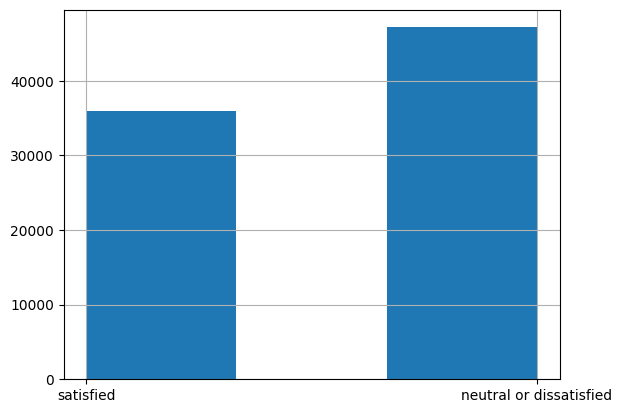

In [12]:
df_train['satisfaction'].hist(bins=3)
df_train['satisfaction'].value_counts()

<ipython-input-13-c395dd526322>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True)


<Axes: >

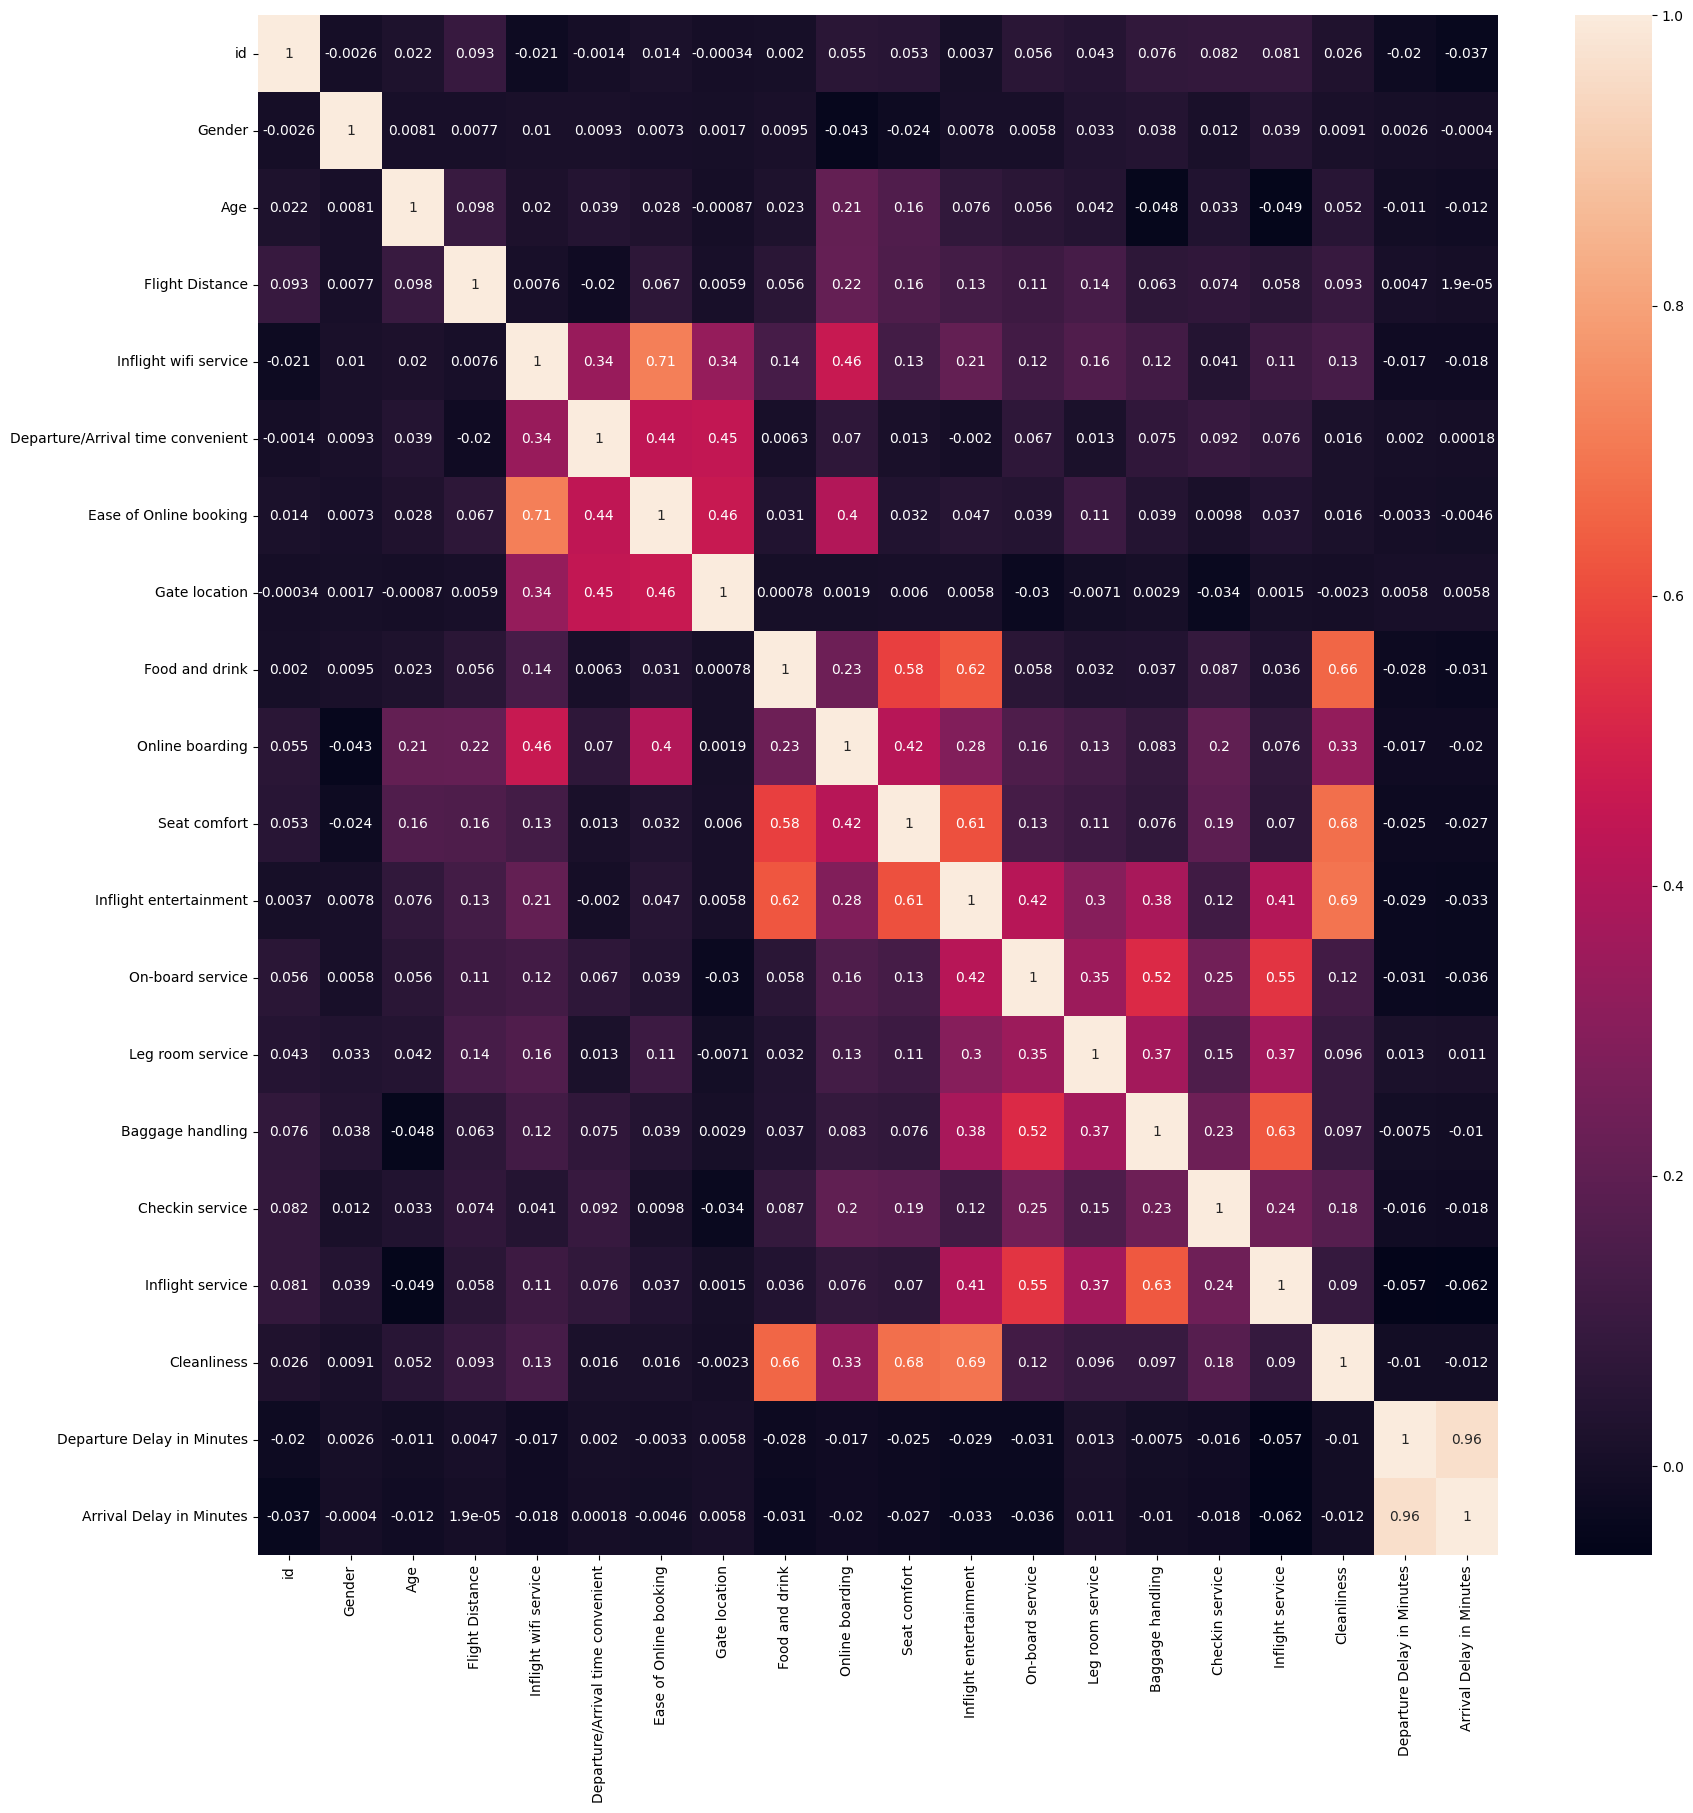

In [13]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_train.corr(), annot=True)

In [14]:
str_columns = []
for str_col in df_train.columns:

    if df_train[str_col].dtype == 'object':
        str_columns.append(str_col)
        
        print(f'--{str_col}--')
        print(df_train[str_col].value_counts())
        print()
str_columns.pop();

--Customer Type--
Loyal Customer       67999
disloyal Customer    15124
Name: Customer Type, dtype: int64

--Type of Travel--
Business travel    57305
Personal Travel    25818
Name: Type of Travel, dtype: int64

--Class--
Business    39701
Eco         37447
Eco Plus     5975
Name: Class, dtype: int64

--satisfaction--
neutral or dissatisfied    47168
satisfied                  35955
Name: satisfaction, dtype: int64



In [15]:
str_columns

['Customer Type', 'Type of Travel', 'Class']

In [16]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer

ohe_cat = OneHotEncoder()
new_columns = []
knnimp = KNNImputer(n_neighbors=5, weights='uniform')

def processing_data(df_raw, train=True):

    df = df_raw.copy()

    if train:
        df_ohe_cat = pd.DataFrame(ohe_cat.fit_transform(df[str_columns[:-1]].values).toarray())

        for col in str_columns[:-1]:
            for val in df[col].unique():
                new_columns.append(col + '_' + val)

    else:
        df_ohe_cat = pd.DataFrame(ohe_cat.transform(df[str_columns[:-1]].values).toarray())

    ind = 0
    for ind, col in enumerate(new_columns):
        df[col] = df_ohe_cat.iloc[:, ind]
    for col in str_columns[:-1]:
        df = df.drop(col, axis=1)

    dict_class = {'Eco': 0, 'Eco Plus': 1, 'Business': 2}
    df[str_columns[-1]] = df[str_columns[-1]].map(lambda x : dict_class[x])

    if train:
        df['satisfaction'] = df['satisfaction'].map(lambda x : int(x == 'satisfied'))


    if train:
        df_train_KNN = knnimp.fit_transform(df.drop('satisfaction', axis=1))
        df_train_KNN = pd.DataFrame(df_train_KNN, columns=df.drop('satisfaction', axis=1).columns)
        df_train_KNN['satisfaction'] = df['satisfaction']
        df = df_train_KNN.copy()
    else:
        df_train_KNN = knnimp.transform(df)
        df = pd.DataFrame(df_train_KNN, columns=df.columns)
    
    df.drop('id', axis=1, inplace=True)

    return df

In [17]:
df_train_rdy = processing_data(df_train)

df_train_rdy.head()

,Gender,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,satisfaction
0,0.0,26.0,2.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,...,4.0,4.0,5.0,0.0,0.0,1.0,0.0,1.0,0.0,1
1,0.0,25.0,2.0,562.0,2.0,5.0,5.0,5.0,2.0,2.0,...,1.0,4.0,2.0,11.0,9.0,1.0,0.0,1.0,0.0,0
2,0.0,26.0,0.0,1180.0,3.0,4.0,2.0,1.0,1.0,2.0,...,4.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,1.0,47.0,0.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,...,3.0,5.0,2.0,9.0,23.0,1.0,0.0,0.0,1.0,0
4,0.0,41.0,2.0,853.0,1.0,2.0,2.0,2.0,4.0,3.0,...,4.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [18]:
# sns.boxplot(df_train_rdy['Flight Distance'])

df_train_rdy['Flight Distance'][df_train_rdy['Flight Distance'] > 3800]
df_train_rdy.groupby(df_train_rdy['Flight Distance'] > df_train_rdy['Flight Distance'].mean())[['satisfaction']].apply(lambda x : (x.sum(), x.count() - x.sum()))

Flight Distance
False    ([17495], [35873])
True     ([18460], [11295])
dtype: object

In [19]:
df_train_rdy.groupby(['Gender', df_train_rdy['Departure Delay in Minutes'] > 5, df_train_rdy['Arrival Delay in Minutes'] > 5])[['satisfaction']].apply(lambda x : (x.sum(), x.count() - x.sum()))

Gender  Departure Delay in Minutes  Arrival Delay in Minutes
0.0     False                       False                       ([11367], [13113])
                                    True                          ([1244], [2365])
        True                        False                         ([1435], [1582])
                                    True                          ([3886], [7100])
1.0     False                       False                       ([11436], [12583])
                                    True                          ([1190], [2191])
        True                        False                         ([1476], [1451])
                                    True                          ([3921], [6783])
dtype: object

In [20]:
df_train_rdy['mean_level'] = df_train_rdy.loc[:, 'Inflight wifi service':'Cleanliness'].mean(axis=1)
df_train_rdy['true'] = ((df_train_rdy['Departure Delay in Minutes'] > 15) & (df_train_rdy['Arrival Delay in Minutes'] > 15)).map(lambda x : int(x))
df_train_rdy['dist'] = (df_train_rdy['Flight Distance'] > df_train_rdy['Flight Distance'].mean()).map(lambda x : int(x))

dist = df_train_rdy['Flight Distance'].mean()

In [21]:
df_train_rdy.head()

,Gender,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Departure Delay in Minutes,Arrival Delay in Minutes,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,satisfaction,mean_level,true,dist
0,0.0,26.0,2.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1,3.714286,0,0
1,0.0,25.0,2.0,562.0,2.0,5.0,5.0,5.0,2.0,2.0,...,11.0,9.0,1.0,0.0,1.0,0.0,0,3.000000,0,0
2,0.0,26.0,0.0,1180.0,3.0,4.0,2.0,1.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0,2.500000,0,0
3,1.0,47.0,0.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,...,9.0,23.0,1.0,0.0,0.0,1.0,0,2.785714,0,1
4,0.0,41.0,2.0,853.0,1.0,2.0,2.0,2.0,4.0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0,2.071429,0,0


In [22]:
X, y = df_train_rdy.drop('satisfaction', axis=1), df_train_rdy['satisfaction']

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(2)
X = poly.fit_transform(X)

std = StandardScaler()
X_norm = std.fit_transform(X)

In [24]:
# from sklearn.preprocessing import StandardScaler

# std = StandardScaler()
# X_norm = std.fit_transform(X)
# X_norm = pd.DataFrame(X_norm, columns=X.columns)

In [25]:
# X_norm.head()

AttributeError: ignored

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=42, stratify=y)

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='ovr', solver='liblinear')

model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [28]:
# from sklearn.model_selection import GridSearchCV

# model_gscv = GridSearchCV(model, param_grid={
#                                              'solver': ['lbfgs', 'liblinear'],
#                                              'Cs': [-1, 3, 5, 10]
#                                              },
#                                             scoring='f1_micro', 
#                                             refit=True,
#                                             return_train_score=True, 
#                                             verbose=2)

In [29]:
# model_gscv.fit(X_train, y_train)

In [30]:
# model_gscv.best_score_

In [31]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))

0.9412118538717569


In [32]:
model.score(X_test, y_test)

0.9412118538717569

In [33]:
df_test.sample(5)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
2389,87005,0,Loyal Customer,60,Personal Travel,Eco,907,1,4,2,...,5,3,3,2,3,4,3,4,13,1.0
15238,48949,0,Loyal Customer,63,Business travel,Business,2681,1,1,1,...,1,5,5,5,5,2,5,1,5,0.0
14490,64327,0,disloyal Customer,21,Business travel,Eco,1212,4,4,4,...,1,1,2,5,4,2,4,1,18,21.0
18668,28198,1,Loyal Customer,25,Personal Travel,Eco,834,3,1,3,...,2,2,4,5,4,2,3,2,0,0.0
9228,118244,0,Loyal Customer,43,Personal Travel,Business,1788,1,5,1,...,5,3,3,1,3,4,3,3,0,0.0


In [34]:
df_test.isna().sum()

id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             71
dtype: int64

In [35]:
df_test_rdy = processing_data(df_test, train=False)

df_test_rdy.head()

,Gender,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel
0,1.0,15.0,0.0,590.0,2.0,5.0,3.0,3.0,3.0,3.0,...,4.0,5.0,5.0,3.0,32.0,42.0,1.0,0.0,0.0,1.0
1,0.0,23.0,1.0,488.0,4.0,5.0,5.0,5.0,4.0,5.0,...,1.0,5.0,1.0,4.0,0.0,62.0,1.0,0.0,1.0,0.0
2,0.0,25.0,2.0,528.0,1.0,4.0,2.0,1.0,5.0,2.0,...,5.0,4.0,4.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,15.0,0.0,369.0,0.0,4.0,0.0,3.0,2.0,0.0,...,5.0,2.0,5.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,34.0,2.0,604.0,1.0,1.0,1.0,1.0,4.0,4.0,...,4.0,4.0,4.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0


In [36]:
df_test_rdy['mean_level'] = df_test_rdy.loc[:, 'Inflight wifi service':'Cleanliness'].mean(axis=1)
df_test_rdy['true'] = ((df_test_rdy['Departure Delay in Minutes'] > 15) & (df_test_rdy['Arrival Delay in Minutes'] > 15)).map(lambda x : int(x))
df_test_rdy['dist'] = (df_test_rdy['Flight Distance'] > dist).map(lambda x : int(x))

In [37]:
# X_norm = std.transform(df_test_rdy)
# X_norm = pd.DataFrame(X_norm, columns=df_test_rdy.columns)

In [38]:
X = poly.transform(df_test_rdy)
X_norm = std.transform(X)

In [41]:
# X_norm.head()

In [42]:
df_ans = pd.DataFrame()
df_ans['id'] = df_test['id'].map(lambda x : int(x))
df_ans['satisfaction'] = model.predict(X_norm)
df_ans['satisfaction'] = df_ans['satisfaction'].map(lambda x : 'satisfied' if x == 1 else 'neutral or dissatisfied')

df_ans.head()

,id,satisfaction
0,40853,neutral or dissatisfied
1,15070,satisfied
2,104309,neutral or dissatisfied
3,36427,satisfied
4,7630,satisfied


In [43]:
df_ans.to_csv('/content/gdrive/MyDrive/ML_misis_4sem/hw_03/ans.csv', index=False)